In [1]:
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.ert import simulate as simulateERT
import pygimli.physics.ert as ert

In [2]:
# define the geometry
depth = 50
width = 100
plc = mt.createCube(size=[width, width, depth], pos=[0, 0, -depth/2], boundaryMarker=1)

Create a pyGimli configuration

In [3]:
nPerLine = 21
scheme = ert.createERTData(elecs=np.linspace(start=-20, stop=20, num=nPerLine),
                           schemeName='dd')
pos = scheme.sensorPositions().array()

In [4]:
nLine = 8
posLine = np.linspace(-15,15,nLine)
sensors = np.empty((0,3), int)
for i in posLine:
    line = pos
    line[:,1] = i
    sensors = np.append(sensors,line,axis=0)
scheme.setSensors(sensors)

In [5]:
# create the configuration by shifting the reference line config
total_FourPointData = np.empty((0,4),int)
refLine = np.array([scheme['a'],scheme['b'],scheme['m'],scheme['n']]).T
for i in range(nLine):
    total_FourPointData = np.append(total_FourPointData,refLine + i * nPerLine,axis=0)
for i,FourPointer in enumerate(total_FourPointData):
    scheme.createFourPointData(i,total_FourPointData[i,0],total_FourPointData[i,1],total_FourPointData[i,2],total_FourPointData[i,3])

In [6]:
# Force finner meshing at at the sensors by create an additonal node at 1/2 mm in -z-direction
for sensor in scheme.sensors().array():
    plc.createNode(sensor - [0.0, 0.0, 1e-1])

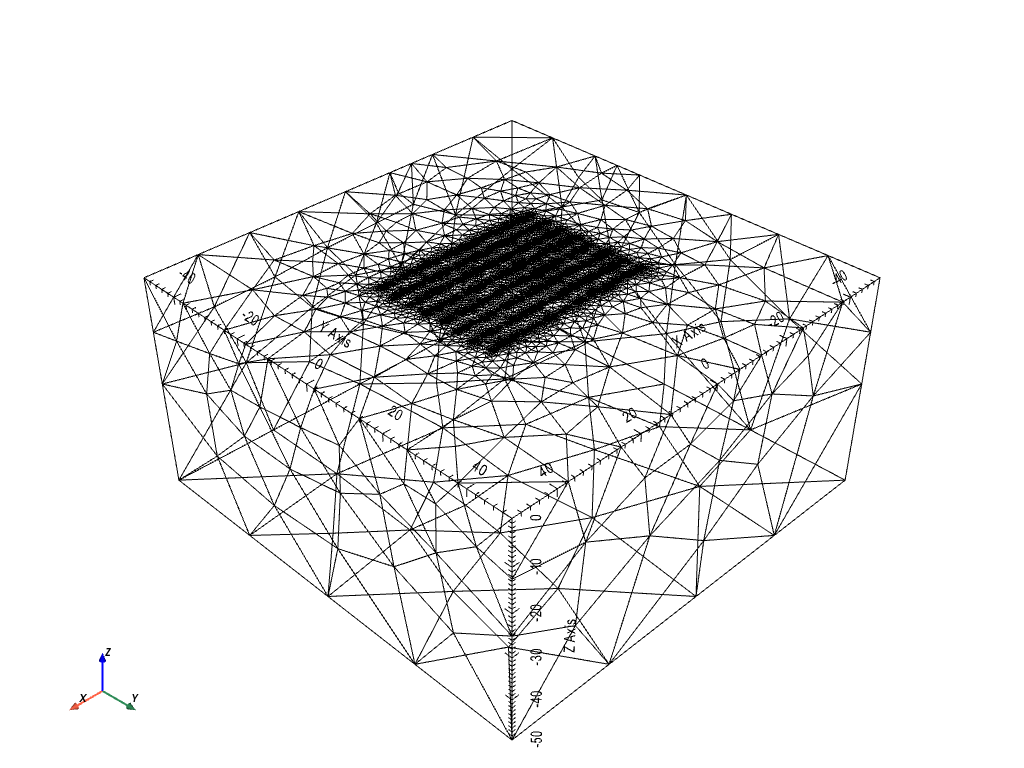

In [7]:
mesh = mt.createMesh(plc)
pg.show(mesh)
mesh.exportVTK('mesh')

In [8]:
hom = simulateERT(mesh, res=1.0, scheme=scheme, sr=False,
                  calcOnly=True, verbose=True)

In [9]:
hom.save('homogeneous.ohm', 'a b m n u')
hom.set('k', 1.0/ (hom('u') / hom('i')))
hom.set('rhoa', hom('k') * hom('u') / hom('i'))

hom.save('simulatedhom.dat', 'a b m n rhoa k u i')

1

### Create a cube geobody with low resistivity 

In [10]:
def defGeom(depth = 30):
    plc0 = plc
    cube = mt.createCube(size=[99, 99, depth], pos=[0, 0, -25], marker=2)
    plc0 += cube 
    mesh = mt.createMesh(plc0)
    return mesh

def runSimu(mesh):
    res = [[1, 10.0], [2, 100.0]]  # map markers 1 and 2 to 10 and 100 Ohmm, resp.
    het = simulateERT(mesh, res=res, scheme=scheme, sr=False,calcOnly=True, verbose=True)
    return het


In [11]:
nIterations = 2
for i in range(nIterations):
    depth = np.random.uniform(27,33)
    mesh = defGeom(depth)
    hetTemp = runSimu(mesh)
    hetTemp.set('k', 1.0/ (hom('u') / hom('i')))
    hetTemp.set('rhoa', hetTemp('k') * hetTemp('u') / hetTemp('i'))

    print(hetTemp['rhoa'])


1368 [9.933376688497482,...,10.245697863049605]
1368 [9.674482520965828,...,10.107814161790456]


In [12]:
hetTemp['rhoa'].array().shape

(1368,)

In [19]:
res = [[1, 10.0], [2, 100.0]]
res = pg.solver.parseArgToArray(res, mesh.cellCount(), mesh)

In [20]:
resArray = np.expand_dims(res.array(),1)

In [43]:
points = mesh.cellCenters().array()

In [103]:
# get the points index in a smaller range to save computation time
np.where((points[:,0]<30)& (points[:,0]>-30))

(176049,)

In [22]:
a = np.concatenate([resArray,mesh.cellCenters().array()],axis = 1)

In [14]:
from scipy.interpolate import griddata

In [15]:
import pyvista as pv

In [46]:
dim = (30, 30, 30)
x_ = np.linspace(-25., 25., 30)
y_ = np.linspace(-25., 25., 30)
z_ = np.linspace(-30., 0., 30)
x, y, z = np.meshgrid(x_, y_, z_, indexing='xy')

In [70]:
xyz = np.stack([x.flatten(),y.flatten(),z.flatten()]).T

In [77]:
request = xyz
values = griddata(points, resArray, request)

In [74]:
# values = np.linspace(0, 10, 30*30*30).reshape((30, 30, 30))

In [78]:
grid = pv.UniformGrid(tuple(x+1 for x in dim))

In [79]:
grid.cell_arrays["values"] = values.flatten(order="F")  # Flatten the array!


In [82]:
values

array([[100.],
       [100.],
       [100.],
       ...,
       [ 10.],
       [ 10.],
       [ nan]])

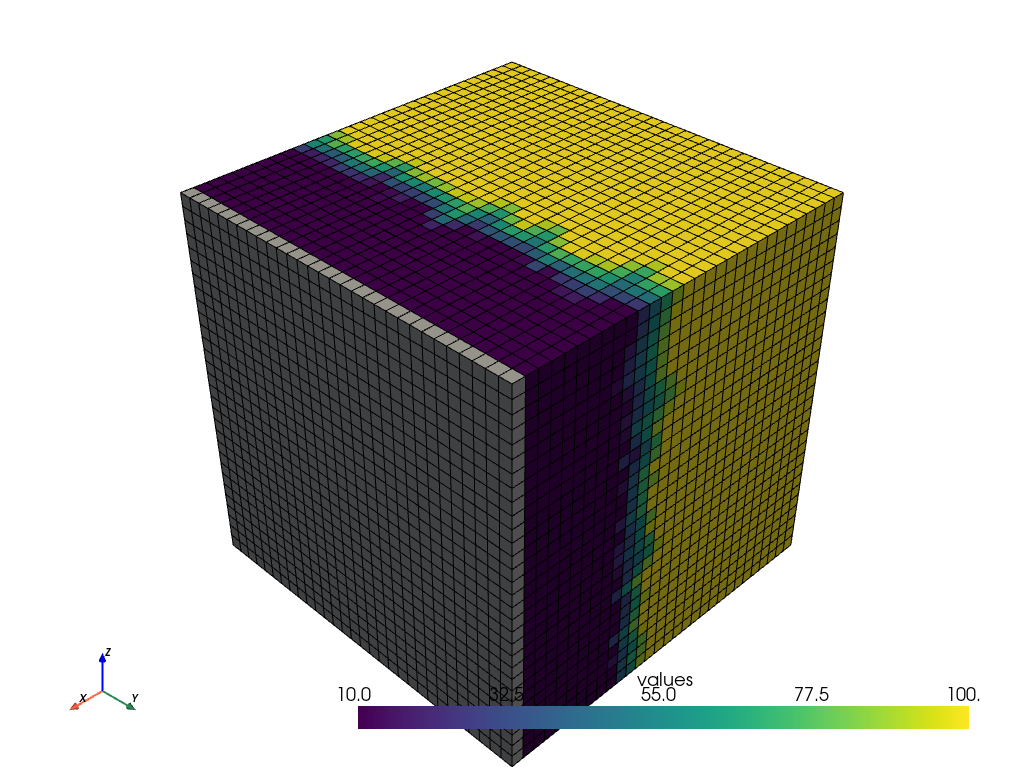

[(72.9555495773441, 72.9555495773441, 72.9555495773441),
 (15.0, 15.0, 15.0),
 (0.0, 0.0, 1.0)]

In [80]:
grid.plot(show_edges=True)
